# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils import annualized_metrics

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# 4 - Momentum Strategy (Mom)

*a) Construct the return to a long-short momentum strategy portfolio. To that effect every month sort stocks into deciles based on their 1-month lagged 11-month return (that is in month $t$ rank stocks based on their $t$−12 to $t$−1 cumulative return). <br></br> Then compute monthly returns for 10 decile portfolios that equal weight all stocks in each decile. Plot the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots. Repeat for value-weighted decile portfolios. Is the evidence consistent with the CAPM?*

In [10]:
# Load the data
data = pd.read_parquet('../data/stock_data.parquet')

data = data[data.permno.isin(data.permno.unique()[:100])]

data.shape

(17377, 15)

In [11]:
# Ensure date is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Calculate cumulative returns for each stock over the past 11 months
data['cum_Rn'] = data.groupby('permno')['Rn'].rolling(11).apply(lambda x: np.prod(1 + x) - 1).reset_index(level=0, drop=True)

# Remove rows with NaN cumulative returns
data = data.dropna(subset=['cum_Rn'])

# Sort stocks into deciles based on cumulative return
data['decile'] = data.groupby('date')['cum_Rn'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)

data['decile'].head()

87    3
86    2
85    3
84    3
83    3
Name: decile, dtype: int64

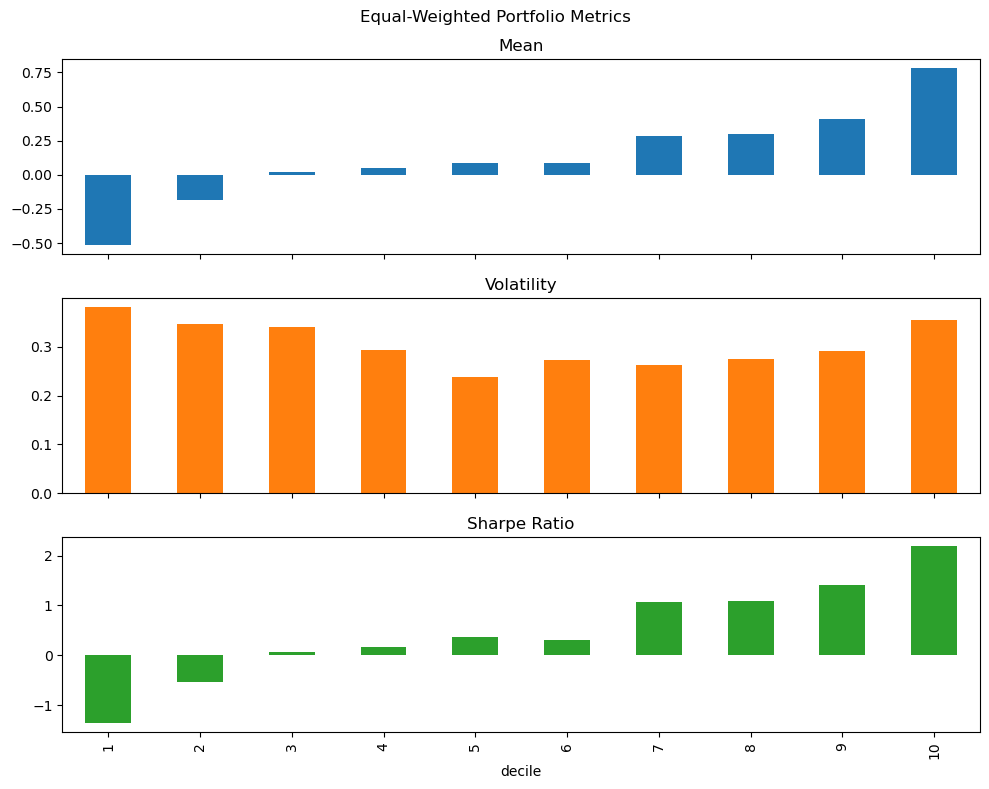

In [12]:
# Step 3: Compute equal-weighted and value-weighted returns for each decile
ew_returns = data.groupby(['date', 'decile'])['Rn'].mean().unstack()

# Calculate annualized mean, standard deviation, and Sharpe ratio
ew_metrics = ew_returns.apply(annualized_metrics, axis=0)

# Plotting the metrics
def plot_metrics(metrics, title):
    metrics_df = metrics.T.rename(columns={0: 'Mean', 1: 'Volatility', 2: 'Sharpe Ratio'})
    metrics_df.plot(kind='bar', subplots=True, layout=(3, 1), figsize=(10, 8), title=title, legend=False)
    plt.tight_layout()
    plt.show()

plot_metrics(ew_metrics, 'Equal-Weighted Portfolio Metrics')

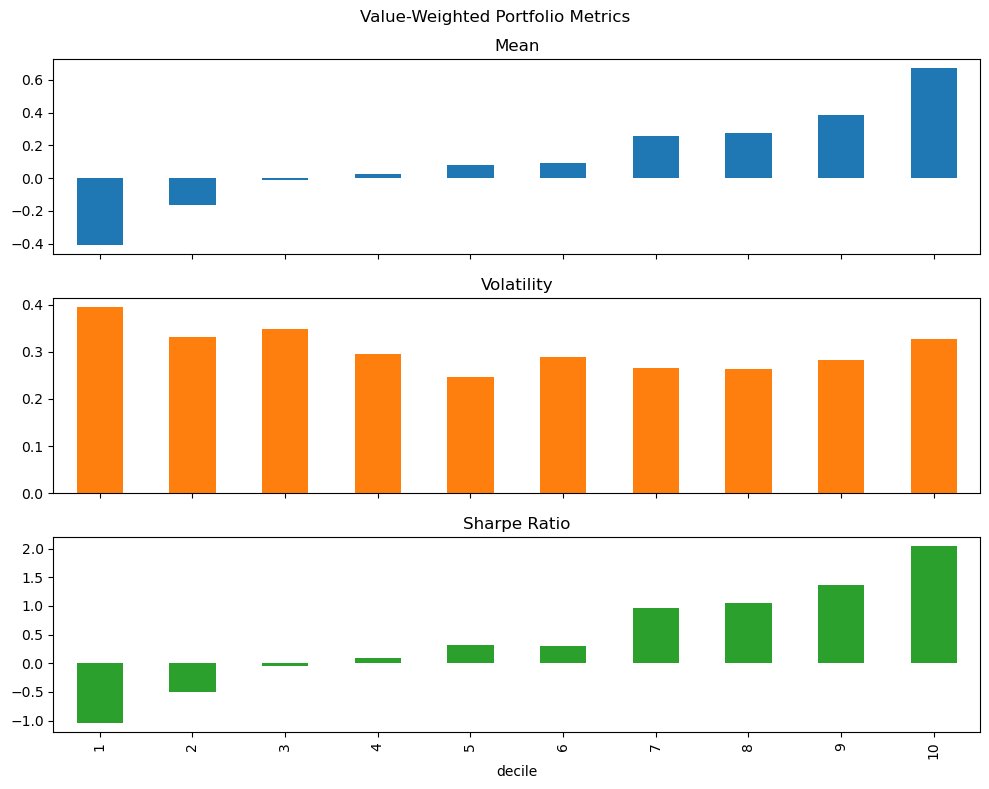

In [13]:
# Step 3: Compute equal-weighted and value-weighted returns for each decile
vw_returns = data.groupby(['date', 'decile']).apply(lambda x: np.average(x['Rn'], weights=x['mcap'])).unstack()

# Calculate annualized mean, standard deviation, and Sharpe ratio
value_weighted_metrics = vw_returns.apply(annualized_metrics, axis=0)

# Plotting the metrics
def plot_metrics(returns, title):
    metrics_df = metrics.T.rename(columns={0: 'Mean', 1: 'Volatility', 2: 'Sharpe Ratio'})
    metrics_df.plot(kind='bar', subplots=True, layout=(3, 1), figsize=(10, 8), title=title, legend=False)
    plt.tight_layout()
    plt.show()

plot_metrics(value_weighted_metrics, 'Value-Weighted Portfolio Metrics')

*b) ..*

Equal-Weighted Long-Short Strategy: t-stat=22.113626615041134, p-value=9.132549961822398e-83


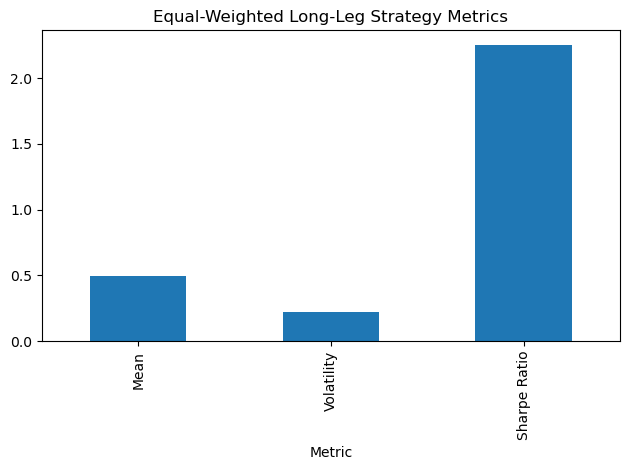

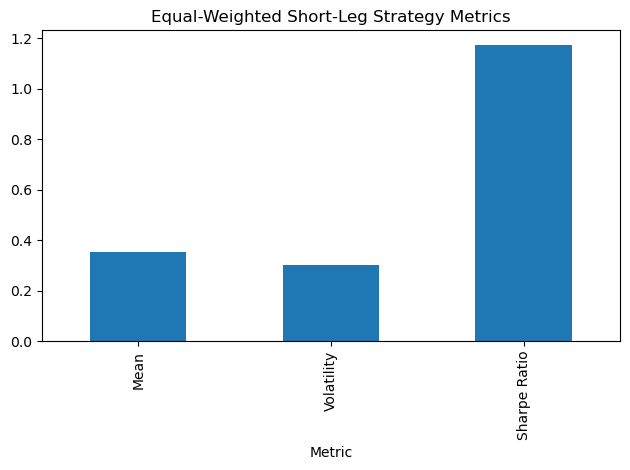

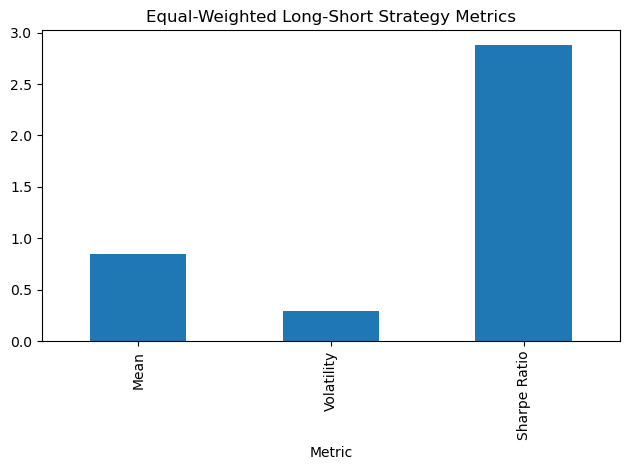

In [14]:
# Step 4: Long-Short Momentum Portfolio
long_equal = ew_returns.loc[:, 8:10].mean(axis=1)
short_equal = - ew_returns.loc[:, 0:2].mean(axis=1)
long_short_equal = ew_returns.loc[:, 8:10].mean(axis=1) - ew_returns.loc[:, 0:2].mean(axis=1)

# Step 5: Statistical significance testing
t_stat_equal, p_value_equal = stats.ttest_1samp(long_short_equal, 0)

# Print the results
print(f"Equal-Weighted Long-Short Strategy: t-stat={t_stat_equal}, p-value={p_value_equal}")

# Plot long-short strategy metrics
def plot_strategy_metrics(strategy_returns, title):
    mean_return, std_dev, sharpe_ratio = annualized_metrics(strategy_returns)
    metrics_df = pd.DataFrame({
        'Metric': ['Mean', 'Volatility', 'Sharpe Ratio'],
        'Value': [mean_return, std_dev, sharpe_ratio]
    })
    metrics_df.plot(kind='bar', x='Metric', y='Value', legend=False, title=title)
    plt.tight_layout()
    plt.show()

plot_strategy_metrics(long_equal, 'Equal-Weighted Long-Leg Strategy Metrics')
plot_strategy_metrics(short_equal, 'Equal-Weighted Short-Leg Strategy Metrics')
plot_strategy_metrics(long_short_equal, 'Equal-Weighted Long-Short Strategy Metrics')

Value-Weighted Long-Short Strategy: t-stat=18.802969827292998, p-value=2.8751421012992492e-64


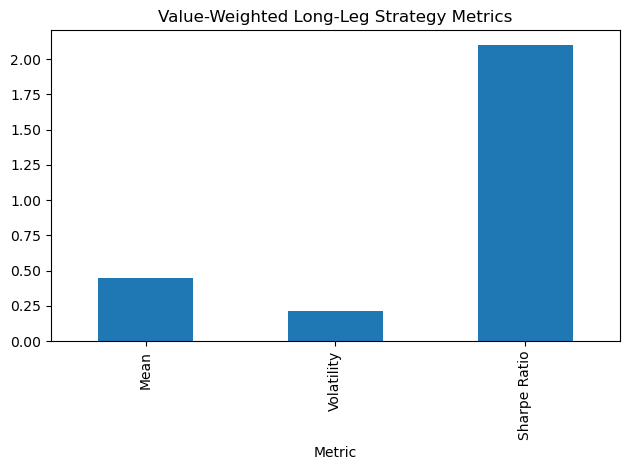

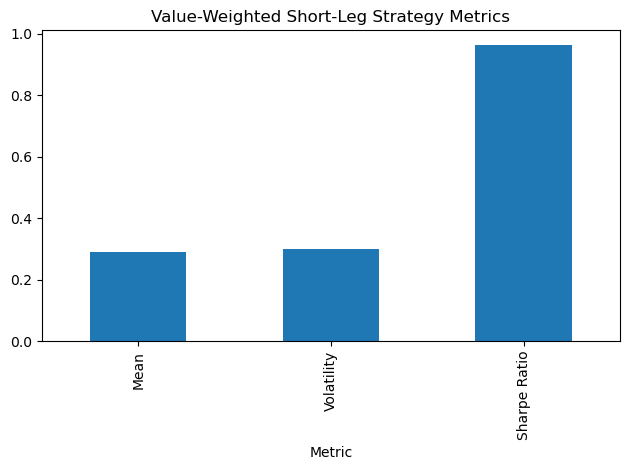

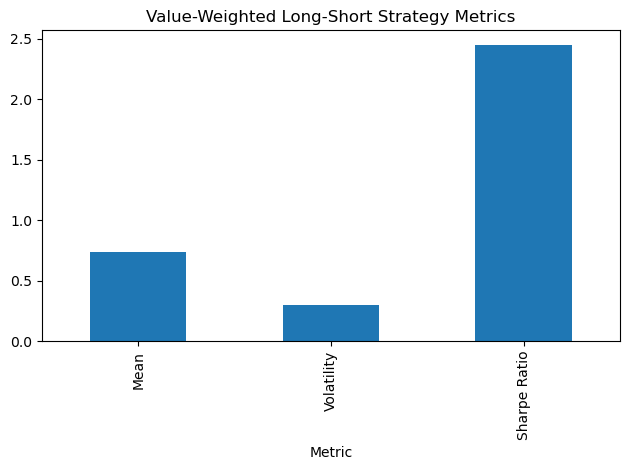

In [15]:
# Step 4: Long-Short Momentum Portfolio
long_value = vw_returns.loc[:, 8:10].mean(axis=1) 
short_value = - vw_returns.loc[:, 0:2].mean(axis=1)
long_short_value = vw_returns.loc[:, 8:10].mean(axis=1) - vw_returns.loc[:, 0:2].mean(axis=1)

# Step 5: Statistical significance testing
t_stat_value, p_value_value = stats.ttest_1samp(long_short_value, 0)

# Print the results
print(f"Value-Weighted Long-Short Strategy: t-stat={t_stat_value}, p-value={p_value_value}")

# Plot long-short strategy metrics
def plot_strategy_metrics(strategy_returns, title):
    mean_return, std_dev, sharpe_ratio = annualized_metrics(strategy_returns)
    metrics_df = pd.DataFrame({
        'Metric': ['Mean', 'Volatility', 'Sharpe Ratio'],
        'Value': [mean_return, std_dev, sharpe_ratio]
    })
    metrics_df.plot(kind='bar', x='Metric', y='Value', legend=False, title=title)
    plt.tight_layout()
    plt.show()
    
plot_strategy_metrics(long_value, 'Value-Weighted Long-Leg Strategy Metrics')
plot_strategy_metrics(short_value, 'Value-Weighted Short-Leg Strategy Metrics')
plot_strategy_metrics(long_short_value, 'Value-Weighted Long-Short Strategy Metrics')